In [21]:
import os
import numpy as np
import cv2
import random 
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, kurtosis 
warnings.filterwarnings('ignore')
import random
import numpy as np

random.seed(42)
np.random.seed(42)



In [22]:
DATASET_PATH = "./cell_images"

def load_images_optimized(path, img_size=(96, 96), max_samples=None): 
    images = []
    labels = []
    
    file_paths = {"Parasitized": [], "Uninfected": []}
    
    for folder_name in ["Parasitized", "Uninfected"]:
        folder_path = os.path.join(path, folder_name)
        if os.path.exists(folder_path):
            files = os.listdir(folder_path)
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths[folder_name].append(os.path.join(folder_path, file))

    if max_samples:
        target_count = max_samples // 2
        
        parasitized_files = random.sample(file_paths["Parasitized"], min(target_count, len(file_paths["Parasitized"])))
        uninfected_files = random.sample(file_paths["Uninfected"], min(target_count, len(file_paths["Uninfected"])))
        
        all_files_to_load = parasitized_files + uninfected_files
        labels = [0] * len(parasitized_files) + [1] * len(uninfected_files) 
    else:
        return load_images_optimized_original(path, img_size)


    for i, img_path in enumerate(all_files_to_load):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        img = cv2.resize(img, img_size)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.medianBlur(img, 3)
        
        images.append(img)
        
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined)

    return np.array(images), np.array(labels)


In [23]:
def extract_hybrid_features(images, batch_size=500):
    all_features = []
    scaler = StandardScaler()
    
    for start in range(0, len(images), batch_size):
        end = min(start + batch_size, len(images))
        batch = images[start:end]
        batch_features = []
        
        for img in batch:
            features_list = []
            
            hog_feat = hog(
                img,
                orientations=9, 
                pixels_per_cell=(8, 8),
                cells_per_block=(3, 3), 
                block_norm='L2-Hys',
                feature_vector=True
            )
            features_list.append(hog_feat)
            
            lbp_1 = local_binary_pattern(img, P=8, R=1, method='uniform')
            lbp_hist_1, _ = np.histogram(lbp_1.ravel(), bins=10, range=(0, 10), density=True)
            
            lbp_2 = local_binary_pattern(img, P=16, R=2, method='uniform')
            lbp_hist_2, _ = np.histogram(lbp_2.ravel(), bins=18, range=(0, 18), density=True)

            features_list.append(lbp_hist_1)
            features_list.append(lbp_hist_2)
            
            img_glcm = (img / 16).astype(np.uint8)
            glcm = graycomatrix(img_glcm, distances=[1, 2], angles=[0, np.pi/4, np.pi/2], levels=16, symmetric=True, normed=True)
            glcm_features = []
            for prop in ['contrast', 'dissimilarity', 'energy', 'ASM']:
                glcm_features.extend(graycoprops(glcm, prop).ravel())
            
            features_list.append(np.array(glcm_features))
            
            stat_features = [
                img.mean(), img.std(), img.max() - img.min(), 
                skew(img.ravel()), kurtosis(img.ravel())
            ]
            features_list.append(np.array(stat_features))
            
            combined = np.concatenate(features_list)
            batch_features.append(combined)
        
        all_features.extend(batch_features)
    
    X = np.array(all_features)
    return scaler.fit_transform(X)

In [24]:

def apply_pca_optimized(X, n_components=50, batch_size=500): 
    ipca = IncrementalPCA(n_components=n_components)
    
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        ipca.partial_fit(X[start:end])
    
    X_pca = ipca.transform(X)
    
    variance = np.sum(ipca.explained_variance_ratio_)
    print(f"PCA Variance Retained: {variance*100:.2f}% (Dimensions: {X_pca.shape[1]})")
    
    return X_pca



In [25]:

def find_optimal_clusters(X, max_k=10):
    """Elbow Method + Silhouette Score"""
    inertias = []
    silhouettes = []
    K_range = range(2, max_k+1)
    
    print(" Calculating Inertia and Silhouette scores for K=2 to K=10...")
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20) 
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouettes, 'ro-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 
    
    best_k = K_range[np.argmax(silhouettes)]
    print(f"Optimal K (based on Silhouette): {best_k}")
    return best_k


In [26]:
def compare_clustering_methods(X, y_true):
    methods = {'K-Means': KMeans(n_clusters=2, random_state=42, n_init=20)}
    results = {}
    
    for name, model in methods.items():
        print(f"\n{'='*50}")
        print(f"📊 Testing: {name}")
        print('='*50)
        
        y_pred = model.fit_predict(X)
        y_mapped = map_clusters_to_labels(y_true, y_pred)
        sil_score = silhouette_score(X, y_pred)
        
        print(classification_report(
            y_true, y_mapped,
            target_names=["Parasitized", "Uninfected"],
            digits=4
        ))
        
        results[name] = {
            'accuracy': (y_true == y_mapped).mean(),
            'silhouette': sil_score
        }
    
    return results



In [27]:

def map_clusters_to_labels(y_true, y_cluster):
    mapping = {}
    y_true = y_true.astype(int)
    for cluster in np.unique(y_cluster):
        true_labels = y_true[y_cluster == cluster]
        if len(true_labels) > 0:
            majority = np.bincount(true_labels).argmax() 
            mapping[cluster] = majority
    mapped_labels = np.vectorize(mapping.get)(y_cluster)
    if mapped_labels.dtype == object:
        mapped_labels[mapped_labels == None] = np.bincount(y_true).argmax()
        mapped_labels = mapped_labels.astype(int)
    return mapped_labels


In [28]:
from sklearn.decomposition import PCA

def plot_clusters_with_labels(X, cluster_labels, true_labels):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))

    for label, name, color in zip(
        [0, 1],
        ["Parasitized", "Uninfected"],
        ["red", "green"]
    ):
        idx = (true_labels == label)
        plt.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            label=name,
            alpha=0.6
        )

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("K-Means Clusters with Class Labels")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [29]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Parasitized', 'Uninfected']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12, color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



 Loading images...
 Loaded 10000 images

 Extracting advanced features (HOG+LBP+GLCM)...
 Feature shape: (10000, 8157)

 Applying PCA with 50 components (Noise Reduction)...
PCA Variance Retained: 35.87% (Dimensions: 50)
 PCA shape: (10000, 50)

 Finding optimal K and plotting Elbow/Silhouette graphs...
 Calculating Inertia and Silhouette scores for K=2 to K=10...


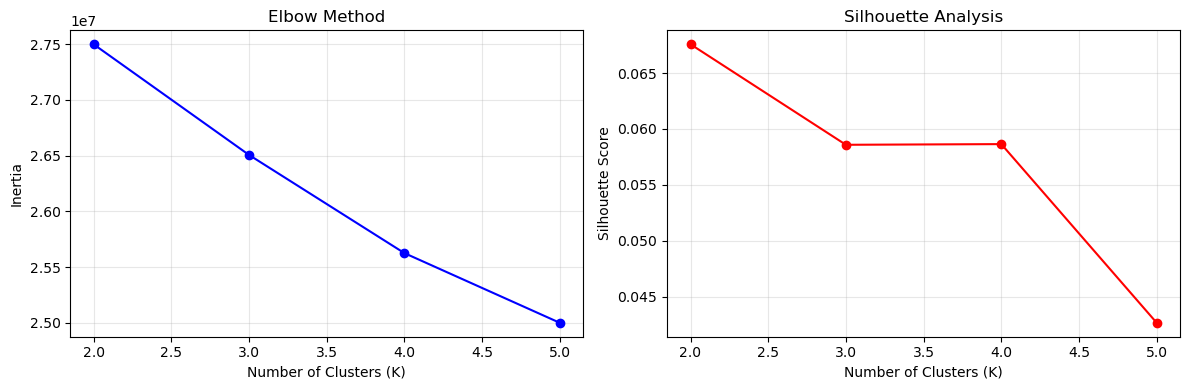

Optimal K (based on Silhouette): 2

 Comparing clustering methods (K-Means K=2)...

📊 Testing: K-Means
              precision    recall  f1-score   support

 Parasitized     0.6811    0.7686    0.7222      5000
  Uninfected     0.7345    0.6402    0.6841      5000

    accuracy                         0.7044     10000
   macro avg     0.7078    0.7044    0.7032     10000
weighted avg     0.7078    0.7044    0.7032     10000


 FINAL K-MEANS RESULTS:
 Overall Accuracy: 0.7044
 Silhouette Score (K=2): 0.0676

 Plotting clusters (PCA 2D)...


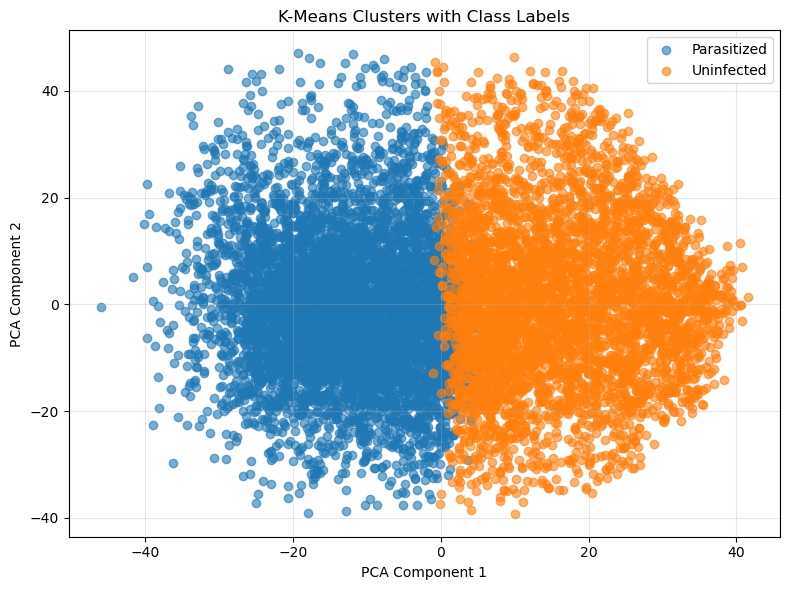

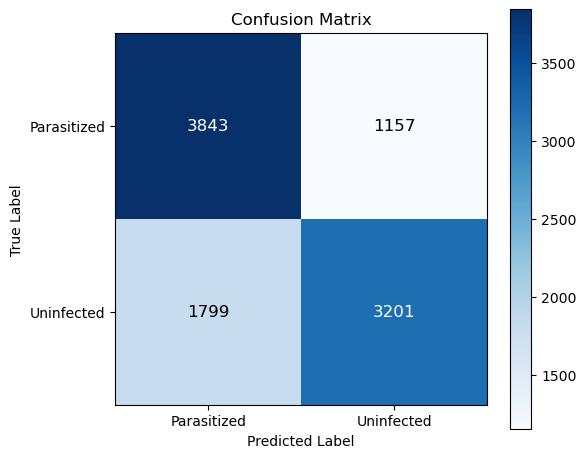


 Done! (Run the code with these major feature/size changes.)


In [30]:

if __name__ == "__main__":
    print(" Loading images...")
    images, labels = load_images_optimized(
        DATASET_PATH,
        img_size=(96, 96),
        max_samples=10000 
    )
    
    print(f" Loaded {len(images)} images")
    
    print("\n Extracting advanced features (HOG+LBP+GLCM)...")
    X = extract_hybrid_features(images)
    print(f" Feature shape: {X.shape}")
    
    print("\n Applying PCA with 50 components (Noise Reduction)...")
    X_pca = apply_pca_optimized(X, n_components=50) 
    print(f" PCA shape: {X_pca.shape}")
    
    print("\n Finding optimal K and plotting Elbow/Silhouette graphs...")
    optimal_k = find_optimal_clusters(X_pca, max_k=5)
    
    print("\n Comparing clustering methods (K-Means K=2)...")
    results = compare_clustering_methods(X_pca, labels)
    
    kmeans_results = results['K-Means']
    
    print("\n" + "="*50)
    print(" FINAL K-MEANS RESULTS:")
    print("="*50)
    
    print(f" Overall Accuracy: {kmeans_results['accuracy']:.4f}")
    print(f" Silhouette Score (K=2): {kmeans_results['silhouette']:.4f}")
    
    kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=20)
    y_pred = kmeans_final.fit_predict(X_pca)
    y_mapped = map_clusters_to_labels(labels, y_pred)
    
    print("\n Plotting clusters (PCA 2D)...")
    plot_clusters_with_labels(X_pca, y_pred, y_mapped)



    plot_confusion_matrix(labels, y_mapped)
    
    print("\n Done! (Run the code with these major feature/size changes.)")

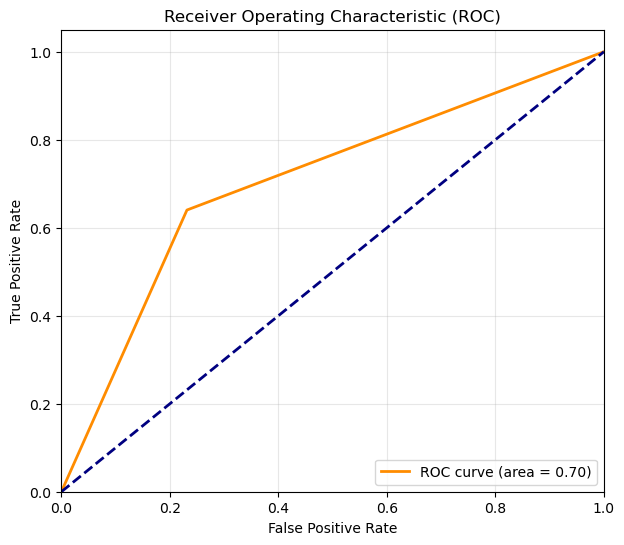

In [31]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

y_scores = y_mapped 
plot_roc_curve(labels, y_scores)


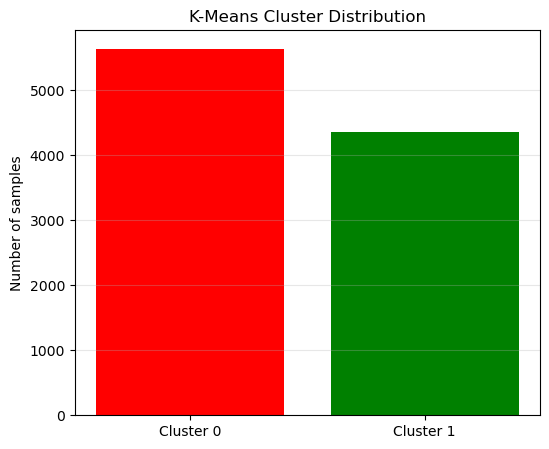

In [32]:
def plot_cluster_distribution(y_cluster, title="Cluster Distribution"):
    unique, counts = np.unique(y_cluster, return_counts=True)
    plt.figure(figsize=(6, 5))
    plt.bar(unique, counts, color=['red', 'green'])
    plt.xticks(unique, ['Cluster 0', 'Cluster 1'])
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_cluster_distribution(y_pred, title="K-Means Cluster Distribution")
